In [12]:
from transformers import BertModel, BertTokenizer, AutoModelForSequenceClassification, AutoTokenizer
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import pandas as pd
import torch
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [13]:
np.random.seed(42)

# Unsupervised Sentiment Analysis

In [14]:
def get_embeddings(model, tokenizer, texts, device='cuda'):
    """Returns the [CLS] token sequence output of the given text"""
    sentence_embeddings = []
    device = torch.device(device)
    
    for batch_idx in tqdm(range(len(texts))):
        batch = texts[batch_idx]
        inp = tokenizer(batch) # Dictionary
        for key in inp.keys():
            inp[key] = torch.tensor([inp[key]], dtype=torch.long, device=device)
        model.to(device)
        model_output = model(**inp)
        sentence_embedding = model_output.last_hidden_state[0][0]
        sentence_embeddings.append(sentence_embedding.cpu().detach().numpy())
        
    return sentence_embeddings

In [22]:
def save_clustering_plots(model_name, model_label, before, tokenizer_name = None):
    before_after = "Before" if before else "After"
    model = BertModel.from_pretrained(model_name)
    if tokenizer_name is None:
        tokenizer = BertTokenizer.from_pretrained(model_name)
    else:
        tokenizer = BertTokenizer.from_pretrained(tokenizer_name)
    sentence_embeddings = get_embeddings(model, tokenizer, data.text.values)
    pca = PCA(2)
    X_pca = pca.fit_transform(sentence_embeddings)
    agglo = AgglomerativeClustering(3)
    preds = agglo.fit_predict(sentence_embeddings)

    plt.scatter(X_pca[:,0],X_pca[:,1], c = preds)
    plt.title(model_label)
    plt.ylabel("P1")
    plt.xlabel("P2")
    plt.savefig(f'./graphs/clustering/{before_after}/{model_label}_cluster_preds.png')
    plt.show()

    plt.scatter(X_pca[:,0], X_pca[:, 1], c = data['label'])
    plt.title(model_label)
    plt.ylabel("P1")
    plt.xlabel("P2")
    plt.savefig(f'./graphs/clustering/{before_after}/{model_label}_lnm_labels.png')
    plt.show()


    data['finbert_label']
    plt.scatter(X_pca[:,0], X_pca[:, 1], c = data['finbert_label'])
    plt.title(model_label)
    plt.ylabel("P1")
    plt.xlabel("P2")
    plt.savefig(f'./graphs/clustering/{before_after}/{model_label}_finbert_labels.png')
    plt.show()

In [23]:
train_data = pd.read_csv('../data/sentiment_analysis/train.csv')
test_data = pd.read_csv('../data/sentiment_analysis/test.csv')

In [24]:
data = pd.concat([train_data, test_data])
data.head()

,text,label
0,Will buy a commercial property & rent it out W...,2
1,I would pay off my house loan. I would start m...,1
2,If I win a lottery for Rs 1 crore tomorrow I w...,2
3,"Use for future security, charity, open my school.",1
4,i will invest 20 lakhs from this & buy propert...,1


In [25]:
def get_labels(model, tokenizer, texts, device='cuda'):
    """Returns the [CLS] token sequence output of the given text"""
    labels = []
    device = torch.device(device)
    
    for batch_idx in tqdm(range(len(texts))):
        batch = texts[batch_idx]
        inp = tokenizer(batch) # Dictionary
        for key in inp.keys():
            inp[key] = torch.tensor([inp[key]], dtype=torch.long, device=device)
        model.to(device)
        model_output = model(**inp)
        logits = model_output.logits[0]
        labels.append(logits.cpu().detach(),dim=-1).numpy())
    
    return labels
   
model = AutoModelForSequenceClassification.from_pretrained('ProsusAI/finbert')
tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert')
labels =get_labels(model,tokenizer,data.text.values)

#   "id2label": {
#     "0": "positive",
#     "1": "negative",
#     "2": "neutral"
#   },
data['finbert_label'] = labels

100%|██████████| 318/318 [00:31<00:00, 10.00it/s]


In [28]:
np.unique(data['finbert_label'])

array([0, 2])

## Before

In [26]:
models = ['bert-base-uncased','ProsusAI/finbert','results/pretraining/bert-base-final']
model_labels = ['BERT', 'FinBERT','BERT-PT']

0it [00:00, ?it/s]
100%|██████████| 318/318 [00:30<00:00, 10.51it/s]


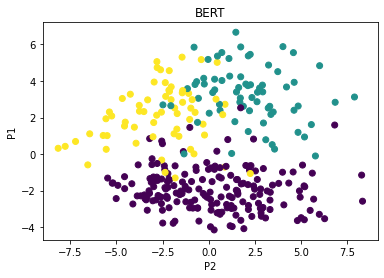

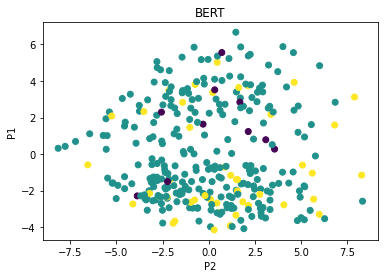

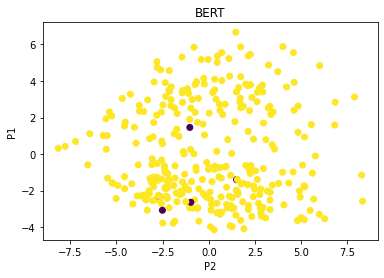

1it [00:42, 42.43s/it]
100%|██████████| 318/318 [00:23<00:00, 13.75it/s]


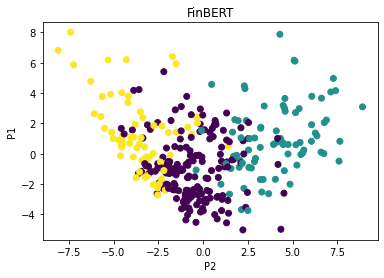

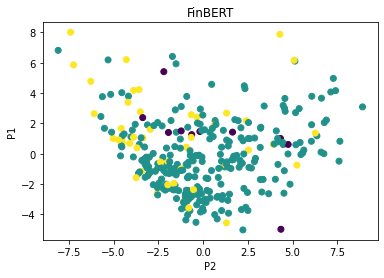

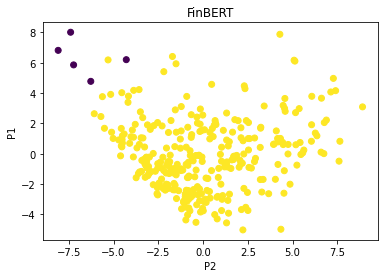

2it [01:17, 40.30s/it]404 Client Error: Not Found for url: https://huggingface.co/results/pretraining/bert-base-final/resolve/main/config.json
2it [01:19, 39.55s/it]


OSError: Can't load config for 'results/pretraining/bert-base-final'. Make sure that:

- 'results/pretraining/bert-base-final' is a correct model identifier listed on 'https://huggingface.co/models'

- or 'results/pretraining/bert-base-final' is the correct path to a directory containing a config.json file



In [27]:
for model_name, model_label in tqdm(zip(models, model_labels)):
    save_clustering_plots(model_name, model_label, before=True)

### After

In [ ]:
models = ['results/sentiment_analysis/bert-base/bert-base-model','results/sentiment_analysis/finbert-base/finbert-base-model','results/sentiment_analysis/pretrain-bert-base/pretrain-bert-base-final']
model_labels = ['BERT', 'FinBERT','BERT-PT']
tokenizer_names = ['bert-base-uncased','ProsusAI/finbert','bert-base-uncased']

In [ ]:
for model_name, model_label, tokenizer_name in tqdm(zip(models, model_labels, tokenizer_names)):
    save_clustering_plots(model_name, model_label, before=True, tokenizer_name=tokenizer_name)